In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm
import os

In [ ]:
dest_path = "Chest_X_Ray_Images_(Pneumonia)_project/"

In [4]:
# import zipfile
# from tqdm import tqdm

# # Specify the path to the ZIP file
# zip_path = "Chest X-Ray Images (Pneumonia).zip"

# # Specify the destination directory to extract the files


# # Extract the ZIP file with progress bar
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # Get the total number of files in the ZIP archive
#     total_files = len(zip_ref.namelist())

#     # Extract files with tqdm progress bar
#     with tqdm(total=total_files, desc="Extracting ZIP") as pbar:
#         for file in zip_ref.namelist():
#             zip_ref.extract(file, dest_path)
#             pbar.update(1)

In [5]:
def explore_dataset(dataset_dir):
    # Get the paths to the train, test, and validation directories
    train_dir = os.path.join(dataset_dir, "train")
    test_dir = os.path.join(dataset_dir, "test")
    val_dir = os.path.join(dataset_dir, "val")

    # Count the number of images in each category (normal and pneumonia) in the train set
    train_normal_images = os.listdir(os.path.join(train_dir, "NORMAL"))
    train_pneumonia_images = os.listdir(os.path.join(train_dir, "PNEUMONIA"))

    num_train_normal = len(train_normal_images)
    num_train_pneumonia = len(train_pneumonia_images)

    # Count the number of images in each category (normal and pneumonia) in the test set
    test_normal_images = os.listdir(os.path.join(test_dir, "NORMAL"))
    test_pneumonia_images = os.listdir(os.path.join(test_dir, "PNEUMONIA"))

    num_test_normal = len(test_normal_images)
    num_test_pneumonia = len(test_pneumonia_images)

    # Count the number of images in each category (normal and pneumonia) in the validation set
    val_normal_images = os.listdir(os.path.join(val_dir, "NORMAL"))
    val_pneumonia_images = os.listdir(os.path.join(val_dir, "PNEUMONIA"))

    num_val_normal = len(val_normal_images)
    num_val_pneumonia = len(val_pneumonia_images)

    return (num_train_normal, num_train_pneumonia,
            num_test_normal, num_test_pneumonia,
            num_val_normal, num_val_pneumonia)

In [6]:
def visualize_class_distribution(class_labels, train_counts, test_counts, val_counts):
    datasets = ['Training Set', 'Validation Set', 'Test Set']
    counts = [train_counts, val_counts, test_counts]

    plt.figure(figsize=(16, 6))

    for i in range(len(datasets)):
        plt.subplot(1, 3, i+1)
        sns.barplot(x=class_labels, y=counts[i])
        plt.title(f"Distribution of Classes in {datasets[i]}")
        plt.xlabel("Class")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

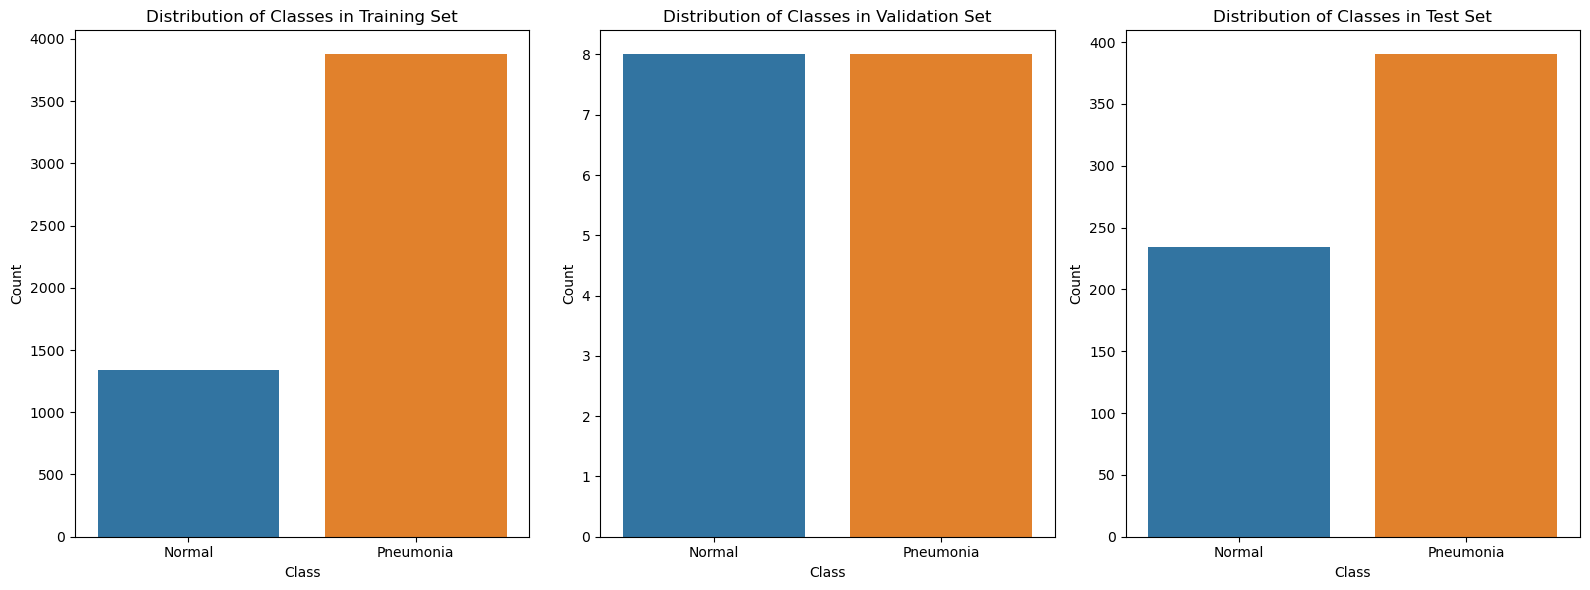

In [7]:
dataset_dir = dest_path+"chest_xray"

# Explore the dataset
num_train_normal, num_train_pneumonia, num_test_normal, num_test_pneumonia, num_val_normal, num_val_pneumonia = explore_dataset(dataset_dir)

# Define class labels and counts
class_labels = ["Normal", "Pneumonia"]
train_counts = [num_train_normal, num_train_pneumonia]
test_counts = [num_test_normal, num_test_pneumonia]
val_counts = [num_val_normal, num_val_pneumonia]

# Visualize class distribution
visualize_class_distribution(class_labels, train_counts, test_counts, val_counts)

# Display sample images
train_normal_samples = [os.path.join(dataset_dir, "train/NORMAL", image) for image in os.listdir(os.path.join(dataset_dir, "train/NORMAL"))[:3]]
train_pneumonia_samples = [os.path.join(dataset_dir, "train/PNEUMONIA", image) for image in os.listdir(os.path.join(dataset_dir, "train/PNEUMONIA"))[:3]]

In [8]:
def display_sample_images(image_paths):
    plt.figure(figsize=(12, 6))
    num_samples = len(image_paths)
    for i,image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = image_path.split("/")[-2]
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(img)
        plt.title(str(label).upper())
        plt.axis("off")

    plt.show()

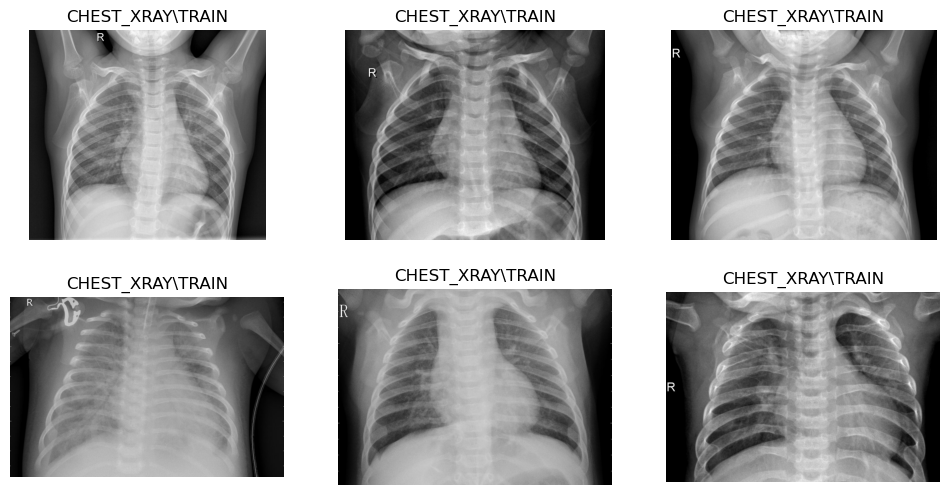

In [9]:
display_sample_images(train_normal_samples + train_pneumonia_samples)

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
torch.cuda.is_available()

True

In [12]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((100, 100)),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((100, 100)),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229])
#     ])
# }


In [18]:
data_dir = "Chest_X_Ray_Images_(Pneumonia)_project/chest_xray/chest_xray"
batch_size = 64

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}


# Load the datasets with ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x),
                                                      transform=data_transforms[x])
                  for x in ['train', 'val','test']}

In [21]:
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image

def generate_augmented_images(dataset, num_augmentations):
    for image, label in dataset:
        yield image, label

        # Apply additional augmentations to the original image
        for _ in range(num_augmentations):
            augmented_image = transforms.Compose([
                # Apply your desired augmentations here
                transforms.Resize((100, 100)),
                transforms.RandomCrop((90, 90)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=(-10, 10)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229])
            ])(image)
            yield augmented_image, label

# Create generators for the augmented datasets
augmented_train_generator = generate_augmented_images(image_datasets["train"], 10)
augmented_val_generator = generate_augmented_images(image_datasets["val"], 50)
augmented_test_generator = generate_augmented_images(image_datasets["test"], 1)

# Create new DataLoaders using the generators
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_generator, batch_size=batch_size, shuffle=True)
augmented_val_loader = torch.utils.data.DataLoader(augmented_val_generator, batch_size=batch_size, shuffle=True)
augmented_test_loader = torch.utils.data.DataLoader(augmented_test_generator, batch_size=batch_size, shuffle=False)


TypeError: object of type 'generator' has no len()

In [99]:
# augmented_loaders = {}
# augmented_dataset = []

# # Iterate over the original validation dataset
# for train_val_test in image_datasets:
#     for image, label in tqdm(image_datasets[train_val_test]):
#         augmented_images = []
#         # Apply the original transformations to the image
#         original_transformed = image
#         augmented_images.append(original_transformed)

#         # Apply additional augmentations to the original image
#         for _ in range(50):
#             augmented_image = data_transforms[train_val_test](transforms.ToPILImage()(image))
#             augmented_images.append(augmented_image)

#         augmented_dataset.extend(augmented_images)

#     # Create a new DataLoader for the augmented validation dataset
#     augmented_loaders[train_val_test] = torch.utils.data.DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


 30%|███████████████████████▋                                                      | 1580/5216 [05:34<12:48,  4.73it/s]


KeyboardInterrupt: 

In [60]:

# Data loading
data_dir = "Chest_X_Ray_Images_(Pneumonia)_project/chest_xray/chest_xray"
batch_size = 64

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale has only one channel
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((100, 100)),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}





# Load the datasets with ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x),
                                                      transform=data_transforms[x])
                  for x in ['train', 'val','test']}

# Create data loaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from  torchvision.models import efficientnet_v2_s,EfficientNet_V2_S_Weights,vgg19
# from tensorflow.python.keras.utils.np_utils import to_categorical
import torch.nn.functional as F

model = vgg19(pretrained=True)

In [ ]:
# Define the model
model = models.vgg19(pretrained=True)
num_classes = len(image_datasets['train'].classes)
num_features = model.classifier[6].in_features

# Modify the model to accept grayscale input
# model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(num_features, num_classes)

# Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30
device

In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(augmented_loaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted_probabilities = torch.sigmoid(outputs)
        labels = F.one_hot(labels, num_classes=2).float()
        labels = labels.to(device)
        loss = criterion(predicted_probabilities, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(augmented_loaders['train'])
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(augmented_loaders['val']):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the val set: {accuracy:.2f}%")
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(augmented_loaders['test']):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the test set: {accuracy:.2f}%")


In [65]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(augmented_loaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted_probabilities = torch.sigmoid(outputs)
        labels = F.one_hot(labels, num_classes=2).float()
        labels = labels.to(device)
        loss = criterion(predicted_probabilities, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(augmented_loaders['train'])
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(augmented_loaders['val']):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the val set: {accuracy:.2f}%")
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(augmented_loaders['test']):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the test set: {accuracy:.2f}%")


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 1/30 - Loss: 0.2587


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


Accuracy on the test set: 86.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:57<00:00,  1.44s/it]


Epoch 2/30 - Loss: 0.0986


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


Accuracy on the test set: 85.74%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:57<00:00,  1.43s/it]


Epoch 3/30 - Loss: 0.0740


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Accuracy on the val set: 81.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.40s/it]


Accuracy on the test set: 84.62%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:58<00:00,  1.45s/it]


Epoch 4/30 - Loss: 0.0610


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Accuracy on the test set: 85.26%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 5/30 - Loss: 0.0511


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Accuracy on the val set: 81.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 88.30%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:58<00:00,  1.44s/it]


Epoch 6/30 - Loss: 0.0441


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]


Accuracy on the test set: 86.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:56<00:00,  1.42s/it]


Epoch 7/30 - Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Accuracy on the test set: 81.57%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:59<00:00,  1.45s/it]


Epoch 8/30 - Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 91.83%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 9/30 - Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


Accuracy on the val set: 75.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Accuracy on the test set: 80.29%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 10/30 - Loss: 0.0339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Accuracy on the test set: 78.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 11/30 - Loss: 0.0394


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


Accuracy on the test set: 84.94%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 12/30 - Loss: 0.0330


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 86.06%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:58<00:00,  1.44s/it]


Epoch 13/30 - Loss: 0.0299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


Accuracy on the test set: 90.22%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:59<00:00,  1.45s/it]


Epoch 14/30 - Loss: 0.0267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Accuracy on the test set: 90.22%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.39s/it]


Epoch 15/30 - Loss: 0.0274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Accuracy on the test set: 84.46%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.39s/it]


Epoch 16/30 - Loss: 0.0250


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 83.97%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 17/30 - Loss: 0.0252


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 84.46%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 18/30 - Loss: 0.0202


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Accuracy on the val set: 87.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Accuracy on the test set: 84.13%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:54<00:00,  1.39s/it]


Epoch 19/30 - Loss: 0.0149


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


Accuracy on the test set: 88.78%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [02:04<00:00,  1.52s/it]


Epoch 20/30 - Loss: 0.0134


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Accuracy on the test set: 82.53%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 21/30 - Loss: 0.0127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Accuracy on the test set: 85.90%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 22/30 - Loss: 0.0182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Accuracy on the val set: 75.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Accuracy on the test set: 78.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:52<00:00,  1.37s/it]


Epoch 23/30 - Loss: 0.0118


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Accuracy on the test set: 86.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:52<00:00,  1.37s/it]


Epoch 24/30 - Loss: 0.0060


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Accuracy on the test set: 83.33%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:55<00:00,  1.41s/it]


Epoch 25/30 - Loss: 0.0063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Accuracy on the test set: 91.19%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:52<00:00,  1.37s/it]


Epoch 26/30 - Loss: 0.0125


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Accuracy on the val set: 62.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


Accuracy on the test set: 78.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:52<00:00,  1.38s/it]


Epoch 27/30 - Loss: 0.0209


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


Accuracy on the val set: 100.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Accuracy on the test set: 88.46%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 28/30 - Loss: 0.0067


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Accuracy on the val set: 81.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Accuracy on the test set: 86.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 29/30 - Loss: 0.0047


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Accuracy on the val set: 81.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


Accuracy on the test set: 87.02%


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:53<00:00,  1.38s/it]


Epoch 30/30 - Loss: 0.0143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Accuracy on the val set: 93.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]

Accuracy on the test set: 85.42%


## Test diff aug

In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted_probabilities = torch.sigmoid(outputs)
        labels = F.one_hot(labels, num_classes=2).float()
        labels = labels.to(device)
        loss = criterion(predicted_probabilities, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(image_datasets['train'])
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders['val']):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the val set: {accuracy:.2f}%")
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders['test']):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the test set: {accuracy:.2f}%")


In [ ]:
test_transform =  transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


# Load the datasets with ImageFolder
image_dataset_test = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, "test"),
                                                      transform=test_transform)
dataloader_test = torch.utils.data.DataLoader(image_dataset_test, batch_size=1, shuffle=True)

## test the results

In [55]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders['test']):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = 100.0 * correct_predictions / total_predictions
print(f"Accuracy on the test set: {accuracy:.2f}%")


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [00:31<00:00, 19.50it/s]

Accuracy on the test set: 77.72%
